# Data cleaning and feature engineering

As we saw in the previous notebook, it takes only a handful of lines to train (`fit`) a machine learning model and start making predictions.
We also saw how we can use [scikit-learn's APIs](https://scikit-learn.org/stable/modules/classes.html) to see what hyperparameters are available to us, but tweaking hyperparameters is the easy part.

You'll spend a lot of time in machine learning understanding your dataset and pre-processing it to improve results.
Most pre-processing, such as simple data cleaning and basic feature engineering, can be done easily with pandas and NumPy, which we load next.

In [1]:
import matplotlib.pyplot as plt
import math
import os
import pandas as pd

## Data cleaning

The first step in any machine learning task is to collect the dataset.
Once you've done that, load it using pandas's `read_csv` function.
By default, pandas loads the headers automatically from the first line, but you can disable it by passing `header=0` as a parameter.
You can also provide your own column names; read [the documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) for more information.

> Note: You can load other types of datasets using pandas, not just CSV files.

In [2]:
df = pd.read_csv('data/titanic-train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


pandas's `.info()` gives us basic information about the dataset we just loaded.
It tells us:

- How many features (columns) we have, and what their names are
- How many rows have null or empty values for each feature
- The data type of each row

This information is already very useful.
Only 204 of 891 rows have cabin information, so it probably wouldn't make sense to remove rows with null information because that would decimate our dataset (although we could decide to remove the cabin column).

> Note: We can also use the `.shape` property to get the number of rows and columns in the dataset.

In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(891, 12)

The passenger ID is unlikely to help us decide if a passenger survived or not: it's just an identifier.
pandas helps us confirm that it is a unique field with the `is_unique` property.
Note how we are calling this property:

1. Specify the `PassengerId` column as a property of the DataFrame (`df.PassengerId`)
2. Call the `is_unique` property on this column (`df.PassengerId.is_unique`)

In [4]:
print("PassengerId is a unique identifier" if df.PassengerId.is_unique
                                           else "PassengerId is not a unique identifier")

PassengerId is a unique identifier


Since `PassengerId` is unique, we can set it as the index (the first column with values in bold).
Here, we're telling the function to do two things: set the index to the `PassengerId` feature, and `drop` the previous index.
That means we can refer to passengers by their ID instead of the default index created by pandas.

In [5]:
# set the index to the `PassengerId` feature, and `drop` the previous index
df = df.set_index('PassengerId', drop=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In many tasks, an important data cleaning step is removing duplicate rows if you're confident they are mistakes in the data.
To remove duplicate rows, you can call the `drop_duplicates` function on the DataFrame.
You can pass a list of column names as the first parameter to consider only those columns when looking for duplicates.

In [6]:
df = df.drop_duplicates([ 'Name' ]) # remove duplicate rows (passengers that have the same name)
# df = df.drop_duplicates([ 'Name', 'Age' ]) # remove passengers that have the same name AND age
df.shape

(891, 11)

## Feature engineering continuous variables

pandas also has some helper functions to find ranges in features.
This can help us decide if we need to normalize the data.

Visualizations can also be helpful.
Except for a few outliers, fares go up to 250, but most ages only go up to 80.

Fare between 0.0 and 512.3292 (average: 32.2)
Age between 0.42 and 80.0 (average: 29.7)


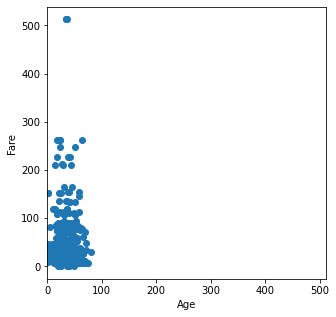

In [7]:
print(f"Fare between { df.Fare.min() } and { df.Fare.max() } (average: { round(df.Fare.mean(), 2) })")
print(f"Age between { df.Age.min() } and { df.Age.max() } (average: { round(df.Age.mean(), 2) })")

# draw a visualization showing the distribution of age and fare
plt.figure(figsize=(5, 5)) # create a figure with a custom size
plt.scatter(df.Age, df.Fare) # draw a scatter plot with age on the x-axis and fare on the y-axis
plt.xlabel('Age') # set the x-label to say 'Age'
plt.ylabel('Fare') # set the y-label to say 'Fare'
plt.xlim(0,512)
plt.show() # show the plot

The verdict is "probably yes": we might need to apply rescaling.
The `Fare`'s range is six times wider than `Age`'s, so depending on the clustering or classification algorithm we use, these incomparable ranges might be harmful.
Thankfully, scikit-learn helps us there too.

scikit-learn's [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) is a handy class to rescale values in columns between 0 and 1.
The process is relatively simple, and similar to when training models:

1. Import the MinMaxScaler class
2. Create a MinMaxScaler instance
3. Transform columns

> Note: We're passing columns using as a 2D array.
        The MinMaxScaler again returns a 2D array, which will overwrite the previous values.

In [8]:
_df = df.copy() # make a copy so we don't overwrite the original dataset

from sklearn import preprocessing # import the preprocessing module, which has many useful preprocessing classes
min_max_scaler = preprocessing.MinMaxScaler() # create a min-max scaler
_df[[ 'Age', 'Fare' ]] = min_max_scaler.fit_transform(df[[ 'Age', 'Fare' ]]) # re-scale each column between 0 and 1
_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,0.271174,1,0,A/5 21171,0.014151,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.472229,1,0,PC 17599,0.139136,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,0.321438,0,0,STON/O2. 3101282,0.015469,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.434531,1,0,113803,0.103644,C123,S
5,0,3,"Allen, Mr. William Henry",male,0.434531,0,0,373450,0.015713,NaN,S


If we check the ranges again, both columns have minimum and maximum values of 0 and 1 respectively.
Now, both ranges are comparable

Fare between 0.0 and 1.0 (average: 0.06)
Age between 0.0 and 1.0 (average: 0.37)


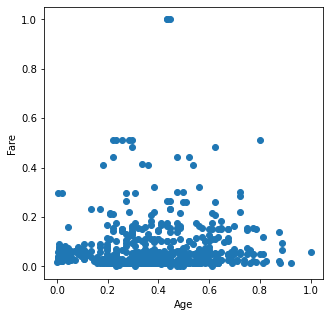

In [9]:
print(f"Fare between { _df.Fare.min() } and { _df.Fare.max() } (average: { round(_df.Fare.mean(), 2) })")
print(f"Age between { _df.Age.min() } and { _df.Age.max() } (average: { round(_df.Age.mean(), 2) })")

# draw a visualization showing the distribution of age and fare
plt.figure(figsize=(5, 5)) # create a figure with a custom size
plt.scatter(_df.Age, _df.Fare) # draw a scatter plot with age on the x-axis and fare on the y-axis
plt.xlabel('Age') # set the x-label to say 'Age'
plt.ylabel('Fare') # set the y-label to say 'Fare'
plt.show() # show the plot

We can do the same thing but using standardization or normalization.
The [StandardScaler class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is helpful to this end.

In [10]:
__df = df.copy() # make a copy so we don't overwrite the original dataset

standard_scaler = preprocessing.StandardScaler() # create a standardization scaler
__df[[ 'Age', 'Fare' ]] = standard_scaler.fit_transform(df[[ 'Age', 'Fare' ]]) # re-scale each column between 0 and 1
__df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,-0.530377,1,0,A/5 21171,-0.502445,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.571831,1,0,PC 17599,0.786845,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,-0.254825,0,0,STON/O2. 3101282,-0.488854,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.365167,1,0,113803,0.420730,C123,S
5,0,3,"Allen, Mr. William Henry",male,0.365167,0,0,373450,-0.486337,NaN,S


This time, `Age` and `Fare` are not bound between 0 and 1, but are shaped like a Gaussian distribution.
The average of this Gaussian distribution is 0, and the standard deviation is 1.

Fare between -0.6484216535389205 and 9.667166525013505 (average: -0.0, standard deviation: 1.0)
Age between -2.0169791879680417 and 3.4651260350566906 (average: 0.0, standard deviation: 1.0)


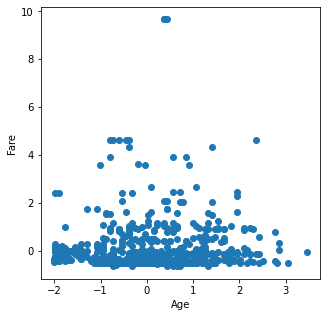

In [11]:
print(f"Fare between { __df.Fare.min() } and { __df.Fare.max() } (average: { round(__df.Fare.mean(), 2) }, standard deviation: { round(__df.Fare.std(), 2) })")
print(f"Age between { __df.Age.min() } and { __df.Age.max() } (average: { round(__df.Age.mean(), 2) }, standard deviation: { round(__df.Age.std(), 2) })")

# draw a visualization showing the distribution of age and fare
plt.figure(figsize=(5, 5)) # create a figure with a custom size
plt.scatter(__df.Age, __df.Fare) # draw a scatter plot with age on the x-axis and fare on the y-axis
plt.xlabel('Age') # set the x-label to say 'Age'
plt.ylabel('Fare') # set the y-label to say 'Fare'
plt.show() # show the plot

We can also undo the rescaling or standardization by calling the `inverse_transform` function on the class instances that we created.
Note that for this to work, we have to provide the same columns that we did when rescaling or standardizing.

In [12]:
standard_scaler.inverse_transform(__df[[ 'Age', 'Fare' ]]) # get the original values (without storing them in the DataFrame)

array([[22.    ,  7.25  ],
       [38.    , 71.2833],
       [26.    ,  7.925 ],
       ...,
       [    nan, 23.45  ],
       [26.    , 30.    ],
       [32.    ,  7.75  ]])

## Feature engineering categorical variables

Feature engineering categorical variables works pretty much in the same way as continuous variables.
scikit-learn again provides more classes that help us encode any type of categorical variable.

To decide what types of variables we have, we can use pandas' `unique` function, which returns all different values of a feature.

> Note: For the sake of this example, we transform first-, second- and third-class to strings.

In [13]:
Pclass = df.Pclass.copy() # create a copy of the passenger class
Pclass = Pclass.replace({ 1: 'first', 2: 'second', 3: 'third' }) # replace numbers with strings
_df.Pclass = Pclass # add the strings to the dataframe

In [14]:
print(f"Unique values of `Sex`: { _df.Sex.unique() }")
print(f"Unique values of `Pclass`: { _df.Pclass.unique() }")
print(f"Unique values of `Embarked`: { _df.Embarked.unique() }")

Unique values of `Sex`: ['male' 'female']
Unique values of `Pclass`: ['third' 'first' 'second']
Unique values of `Embarked`: ['S' 'C' 'Q' nan]


First up: we can use the **[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) for dichotomous variables**.

> Note: The `LabelEncoder` expects a single column at a time, not a 2D array, as was the case previously.

In [15]:
print(f"Unique values of `Sex` before encoding: { df.Sex.unique() }")
label_encoder = preprocessing.LabelEncoder() # create the label encoder
_df.Sex = label_encoder.fit_transform(df.Sex) # transforms `male` to 0 and `female` to 1
print(f"Unique values of `Sex` after encoding: { _df.Sex.unique() }")
_df.head()

Unique values of `Sex` before encoding: ['male' 'female']
Unique values of `Sex` after encoding: [1 0]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,third,"Braund, Mr. Owen Harris",1,0.271174,1,0,A/5 21171,0.014151,NaN,S
2,1,first,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.472229,1,0,PC 17599,0.139136,C85,C
3,1,third,"Heikkinen, Miss. Laina",0,0.321438,0,0,STON/O2. 3101282,0.015469,NaN,S
4,1,first,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.434531,1,0,113803,0.103644,C123,S
5,0,third,"Allen, Mr. William Henry",1,0.434531,0,0,373450,0.015713,NaN,S


The passenger class (`Pclass`) is an **ordinal variable**: first-class is better than second-class, which is better than third-class.
We can use scikit-learn's [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) to convert this column's values to integers.

In [16]:
print(f"Unique values of `Pclass` before encoding: { _df.Pclass.unique() }")

# create the ordinal encoder, telling it what the order is
ordinal_encoder = preprocessing.OrdinalEncoder(categories=[[ 'first', 'second', 'third' ]])

# transform first-, second- and third-class to 0, 1 and 2 respectively
_df[[ 'Pclass' ]] = ordinal_encoder.fit_transform(_df[[ 'Pclass' ]])

print(f"Unique values of `Pclass` after encoding: { _df.Pclass.unique() }")
_df.head()

Unique values of `Pclass` before encoding: ['third' 'first' 'second']
Unique values of `Pclass` after encoding: [2. 0. 1.]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,2.0,"Braund, Mr. Owen Harris",1,0.271174,1,0,A/5 21171,0.014151,NaN,S
2,1,0.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.472229,1,0,PC 17599,0.139136,C85,C
3,1,2.0,"Heikkinen, Miss. Laina",0,0.321438,0,0,STON/O2. 3101282,0.015469,NaN,S
4,1,0.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.434531,1,0,113803,0.103644,C123,S
5,0,2.0,"Allen, Mr. William Henry",1,0.434531,0,0,373450,0.015713,NaN,S


We cannot apply the LabelEncoder or the OrdinalEncoder to the `Embarked` feature.
If we assume that there is no order between ports, or if we assume that the order doesn't matter, then `Embarked` is a **nominal variable**.
Instead, we can use scikit-learn's [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

**Before we can apply one-hot encoding, we have to fill empty values in that column or drop rows with empty values.**
We can do this very easily using pandas.
However, we need to specify that we only want to remove rows whose `Embarked` value is `NaN` (`Not a Number`, used when there is no value).
Otherwise, the function would also remove rows with a `NaN` value for the `Cabin`.
We remove these rows using the `dropna` function.

In [17]:
print(f"Shape before removing rows that have `NaN` values for `Embarked`': { _df.shape }")
_df = _df.dropna(subset=[ 'Embarked' ]) # remove rows with `NaN` as the `Embarked` value 
print(f"Shape after removing rows that have `NaN` values for `Embarked`': { _df.shape }")

Shape before removing rows that have `NaN` values for `Embarked`': (891, 11)
Shape after removing rows that have `NaN` values for `Embarked`': (889, 11)


After removing the rows with `NaN` for the `Embarked` feature, we can proceed normally.
Create the `OneHotEncoder` issue, setting the `sparse` flag to `False`; this lets us insert the new data into our DataFrame more easily.
Then, get the encoding and create three new columns for the three different ports in the Titanic dataset.

In [18]:
print(f"Unique values of `Embarked` before encoding: { _df.Embarked.unique() }")
one_hot_encoder = preprocessing.OneHotEncoder(sparse=False) # create the one-hot encoder
encoding = one_hot_encoder.fit_transform(_df[[ 'Embarked' ]]) # encode the `Embarked` feature
_df[[ 'Embarked_S', 'Embarked_C', 'Embarked_Q' ]] = encoding # store the encoded `Embarked` values in new columns 

# drop the `Embarked` column
# `axis=1` means look for `Embarked` in the column names, not the row indices (`axis=0`)
_df = _df.drop('Embarked', axis=1)
_df.head()

Unique values of `Embarked` before encoding: ['S' 'C' 'Q']


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_S,Embarked_C,Embarked_Q
PassengerId,,,,,,,,,,,,,
1,0,2.0,"Braund, Mr. Owen Harris",1,0.271174,1,0,A/5 21171,0.014151,NaN,0.0,0.0,1.0
2,1,0.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.472229,1,0,PC 17599,0.139136,C85,1.0,0.0,0.0
3,1,2.0,"Heikkinen, Miss. Laina",0,0.321438,0,0,STON/O2. 3101282,0.015469,NaN,0.0,0.0,1.0
4,1,0.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.434531,1,0,113803,0.103644,C123,0.0,0.0,1.0
5,0,2.0,"Allen, Mr. William Henry",1,0.434531,0,0,373450,0.015713,NaN,0.0,0.0,1.0


We can use the `inverse_transform` method on the `LabelEncoder`, `OrdinalEncoder` or `OneHotEncoder` to transform the encoded variables back to their original values.
For example, the next cell shows how to get back the `Embarked` values.

In [19]:
one_hot_encoder.inverse_transform(_df[[ 'Embarked_S', 'Embarked_C', 'Embarked_Q' ]])

array([['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['Q'],
       ['S'],
       ['C'],
       ['C'],
       ['Q'],
       ['S'],
       ['C'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['C'],
       ['Q'],
       ['S'],
       ['Q'],
       ['Q'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
      

## Next steps

We can keep engineering our dataset further.
Try to answer these questions:

- Do we need to engineer the `SibSp` (number of siblings and spouses onboard) and `Parch` (number of parents and children onboard) features?
- Are there any features that you think we don't need?
- We have already encoded some categorical features (`Pclass`, `Sex` and `Embarked`): can we improve any of those fields?

That concludes some of the basic steps you need to carry out in machine learning tasks, depending on your dataset's need and what you intend to do with it.
The next notebook will show us how to eliminate needless variables from our datasets to simplify the data and the machine's learning process.